In [7]:
!pip install gdown

In [8]:
!gdown https://drive.google.com/uc?id=1ffUDYbbKZtwT804PQJywPjZnGRc_U7mq

Downloading...
From (uriginal): https://drive.google.com/uc?id=1ffUDYbbKZtwT804PQJywPjZnGRc_U7mq
From (redirected): https://drive.google.com/uc?id=1ffUDYbbKZtwT804PQJywPjZnGRc_U7mq&confirm=t&uuid=9c0302e0-f618-4cf2-ab0f-3e834d3a306d
To: c:\Users\ebsic\OneDrive\문서\개발\고서인식\chinese.zip

  0%|          | 0.00/165M [00:00<?, ?B/s]
  0%|          | 524k/165M [00:00<01:35, 1.73MB/s]
  1%|          | 1.05M/165M [00:00<00:59, 2.73MB/s]
  1%|▏         | 2.10M/165M [00:00<00:32, 4.99MB/s]
  2%|▏         | 3.15M/165M [00:00<00:26, 6.07MB/s]
  3%|▎         | 4.72M/165M [00:00<00:20, 7.64MB/s]
  4%|▍         | 6.82M/165M [00:00<00:15, 10.1MB/s]
  5%|▌         | 8.39M/165M [00:01<00:15, 9.83MB/s]
  6%|▌         | 9.44M/165M [00:01<00:16, 9.19MB/s]
  7%|▋         | 11.5M/165M [00:01<00:13, 11.2MB/s]
  8%|▊         | 13.1M/165M [00:01<00:14, 10.6MB/s]
  9%|▉         | 14.7M/165M [00:01<00:13, 11.3MB/s]
 10%|▉         | 16.3M/165M [00:01<00:13, 11.0MB/s]
 11%|█         | 17.8M/165M [00:01<00:14, 10.4MB/

In [16]:
import zipfile
with zipfile.ZipFile('chinese.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
%cd chinese

c:\Users\ebsic\OneDrive\문서\개발\고서인식\chinese


In [ ]:
import argparse
import torch, torchvision
from collections import defaultdict
from models.HRCenterNet import *
from models.resnet import *
from utils.utility import *
from pathlib import Path
from info import *
from PIL import Image
from datetime import datetime, timezone, timedelta
'''
input_size = 512
output_size = 512
nms_score = 0.3
iou_threshold = 0.1

tx = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor()
    ])
'''


In [ ]:
class TextDetector(object):
    def __init__(self, device, batch_size):
        self.device = device
        self.batch_size = batch_size
        self.seg_model = HRCenterNet_predict(device = self.device, weight_fn="HRCenterNet_v2021.pth")
        self.recog_model = ResnetCustom(device = self.device, weight_fn="resnet_v2021.pt")

    def segmentation(self, image):
        boxes = self.seg_model(image) 
        return boxes

    def recognition(self, crop_images):
        chars = self.recog_model(crop_images)

        return chars 

    def calc_f1(self, image, gt_boxes):
        pred_boxes = self.segmentation(image)

        if len(pred_boxes) == 0:
            return {'tp' : 0, 'fp' : 0, 'fn' : len(gt_boxes), 'precision' : 0, 'recall' : 0, 'f1_score' : 0}
        fp, fn, success_boxes = calc_f1_with_word(pred_boxes, gt_boxes)
        tp = 0
        for idx in range(0, len(success_boxes), self.batch_size):
            crop_images = []
            batch_labels = []
            batch_box = success_boxes[idx:idx+self.batch_size]
            for box, char in batch_box:
                lx,ly,w,h = list(map(int,box))
                crop_images.append(image.crop((lx,ly,lx+w,ly+h)))
                batch_labels.append(char)
            batch_preds = self.recognition(crop_images)
            positive = sum([ 1 for i,j in zip(batch_preds, batch_labels) if i==j ])
            tp = tp + positive
            fp = fp + len(batch_preds) - positive
        precision = tp / (tp+fp) if tp+fp != 0 else 0
        recall = tp / (tp+fn) if tp+fn != 0 else 0
        f1_score = 2*precision*recall / (precision+recall) if precision+recall != 0 else 0
        return {'tp' : tp, 'fp' : fp, 'fn' : fn, 'precision' : precision, 'recall' : recall, 'f1_score' : f1_score}


In [ ]:
device3 = '0'
device = torch.device(f'cuda:{device3}' if torch.cuda.is_available() else 'cpu')
detector = TextDetector(device, 16)

HRCenterNet_v2021.pth loaded!
resnet_v2021.pt loaded!


In [ ]:
img = Image.open('KakaoTalk_20221221_132602501.jpg')

In [ ]:
# img = Image.open('/home/ubuntu/resnet/sam2.png')

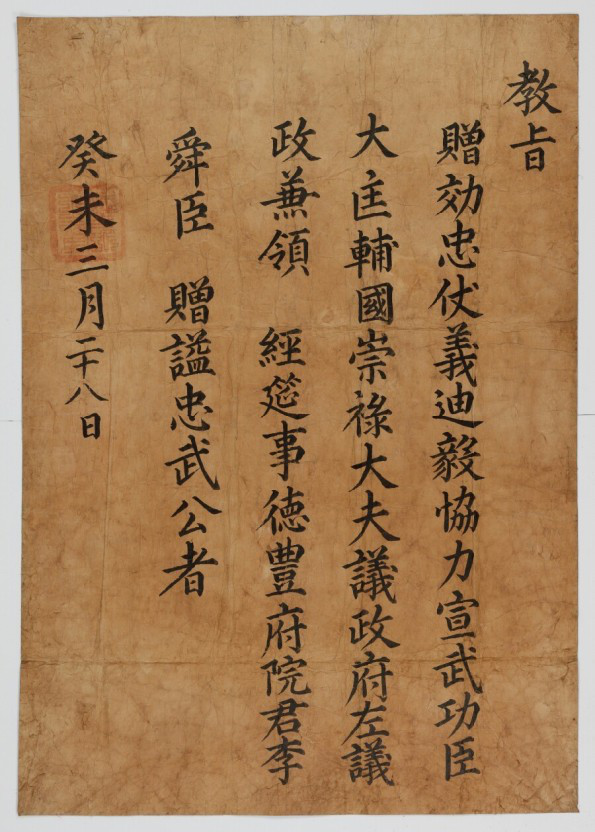

In [ ]:
img

In [ ]:
pred_boxes = detector.segmentation(img)

In [ ]:
len(pred_boxes)

56

In [ ]:
pred_boxes[0][3]

50

In [ ]:
pred_boxes.sort(key=lambda x: (-x[0]//100, x[1]))

In [ ]:
len_ls = []
for i in range(1,10):
    if pred_boxes[i][0] // 100 == pred_boxes[i-1][0] // 100 :
        len_ls.append(abs(pred_boxes[i][1]-pred_boxes[i-1][1]))

mean_len = sum(len_ls) / len(len_ls)
mean_len

52.875

In [ ]:
pred_boxes2 = []
pre_i = 0
for i in range(1,len(pred_boxes)): 
    if pred_boxes[i][0] // 100 == pred_boxes[i-1][0] // 100 :
        if abs(pred_boxes[i][1] - pred_boxes[i-1][1]) > mean_len *1.5 :
            pred_boxes2.append(pred_boxes[pre_i:i])
            pre_i = i
    else :
        if abs(pred_boxes[i][1] - pred_boxes[i-1][1]) < mean_len*len(len_ls)*0.7 :
            pred_boxes2.append(pred_boxes[pre_i:i])
            pre_i = i


pred_boxes2


[[[505, 60, 60, 54], [508, 119, 56, 52]],
 [[434, 119, 56, 48],
  [435, 169, 52, 44],
  [434, 219, 50, 48],
  [432, 273, 52, 44],
  [431, 328, 52, 48],
  [432, 384, 50, 40],
  [429, 431, 56, 50],
  [432, 483, 52, 50],
  [435, 537, 48, 46],
  [432, 587, 50, 50],
  [432, 641, 50, 48],
  [433, 691, 50, 40],
  [434, 738, 50, 46],
  [353, 112, 44, 50],
  [349, 170, 48, 50],
  [348, 224, 50, 50],
  [353, 279, 42, 44],
  [347, 332, 48, 52],
  [344, 389, 52, 46],
  [346, 440, 54, 46],
  [345, 491, 56, 48],
  [344, 547, 58, 52],
  [345, 604, 56, 42],
  [347, 654, 52, 46],
  [342, 705, 54, 34],
  [342, 742, 54, 40],
  [268, 115, 52, 44],
  [263, 164, 56, 54],
  [261, 225, 54, 48]],
 [[256, 323, 54, 44],
  [258, 375, 52, 44],
  [260, 424, 52, 52],
  [261, 483, 50, 50],
  [264, 535, 46, 28],
  [265, 564, 44, 32],
  [262, 611, 48, 42],
  [262, 657, 48, 38],
  [262, 699, 46, 34],
  [261, 743, 46, 36],
  [166, 127, 48, 58],
  [168, 190, 48, 50]]]

In [ ]:
crop_images = []
for i in range(len(pred_boxes2)):
    cr_imge = []
    for idx in range(len(pred_boxes2[i])) :
        lx = pred_boxes2[i][idx][0]
        ly = pred_boxes2[i][idx][1]
        w = pred_boxes2[i][idx][2]
        h = pred_boxes2[i][idx][3]       
        cr_imge.append(img.crop((lx,ly,lx+w,ly+h)))
    crop_images.append(cr_imge)
    # if lx // 100 not in crop_images:
    #     crop_images[lx // 100] = []
    #     crop_images[lx // 100].append(img.crop((lx,ly,lx+w,ly+h)))
    # else :
    #     crop_images[lx // 100].append(img.crop((lx,ly,lx+w,ly+h)))    

    # crop_images.append(img.crop((lx,ly,lx+w,ly+h)))
# crop_images


In [ ]:
result = []
for i in range(len(crop_images)):
    a = detector.recognition(crop_images[i])
    result.append(a)

In [ ]:
final = []
for i in result:
    sen = ''.join(i)
    final.append(sen)

final


['教㫖', '贈効忠仗義迪毅恊力宣武功臣大匡輔國崇祿大夫議政府左議政𠔥領', '𦀇筵事徳曲豆府院君李舜臣']

In [ ]:
for i in final :
    for j in i :
        if j in  ['耶','邪', '也', '於', '焉', '于', '粤', '矣', '哉', '兮', '乎', '之'] :
            print(j,end='\n')
        else :
            print(j,end='')

教㫖贈効忠仗義迪毅恊力宣武功臣大匡輔國崇祿大夫議政府左議政𠔥領𦀇筵事徳曲豆府院君李舜臣